In [1]:
!git clone https://github.com/NVlabs/stylegan

fatal: destination path 'stylegan' already exists and is not an empty directory.


In [2]:
!ls stylegan

config.py	 generate_figures.py	__pycache__	stylegan-teaser.png
datasets	 LICENSE.txt		README.md	training
dataset_tool.py  metrics		results		train.py
dnnlib		 pretrained_example.py	run_metrics.py


In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar xf images.tar.gz
!tar xf annotations.tar.gz

--2019-08-28 15:48:15--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz.2’

images.tar.gz.2     100%[===================>] 755.23M  28.8MB/s    in 27s     

2019-08-28 15:48:43 (27.9 MB/s) - ‘images.tar.gz.2’ saved [791918971/791918971]

--2019-08-28 15:48:43--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz.2’

annotations.tar.gz. 100%[===================>]  18.28M  14.4MB/s    in 1.3s    

2019-08-28 15:48:45 (14.4

(500, 482)


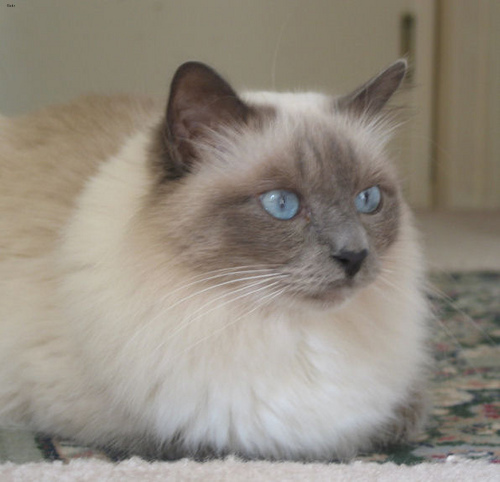

(500, 375)


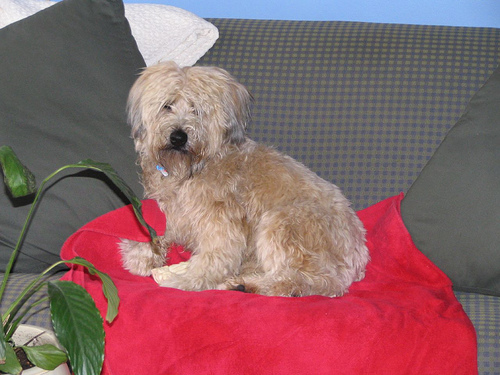

(500, 436)


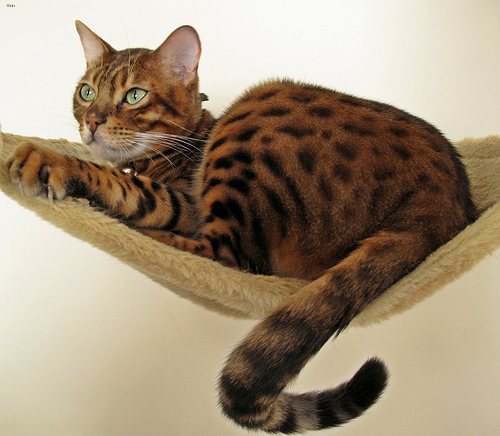

(500, 500)


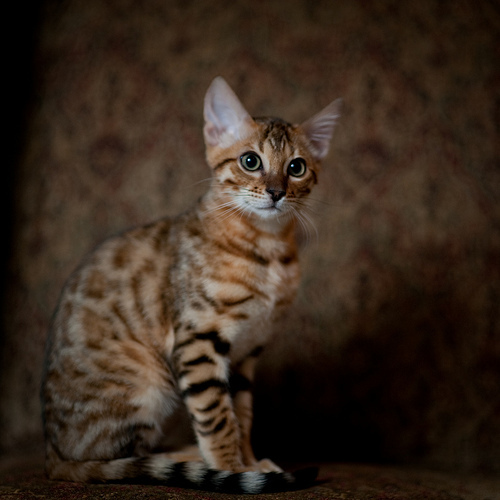

(500, 333)


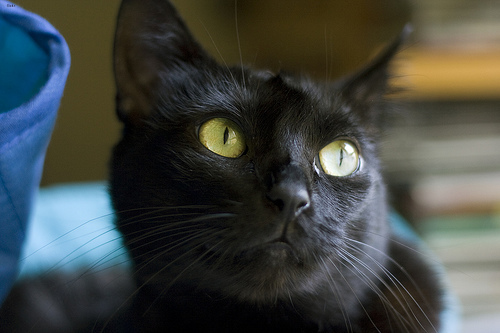

(366, 550)


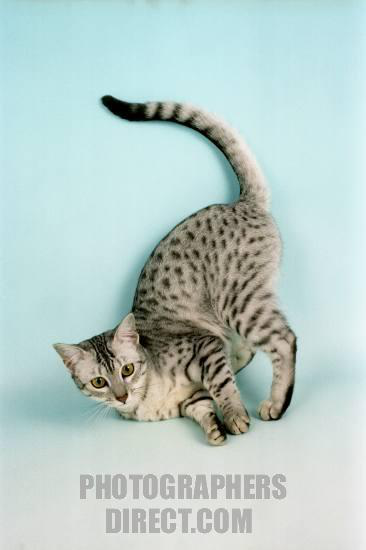

(250, 276)


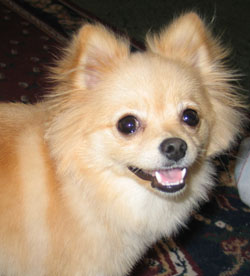

(500, 333)


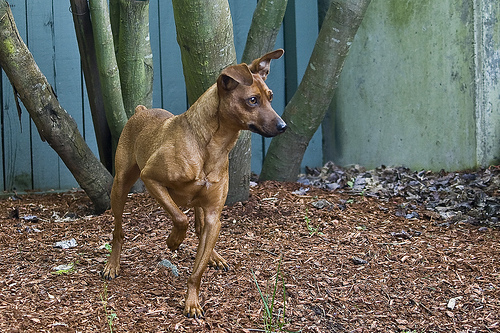

(500, 323)


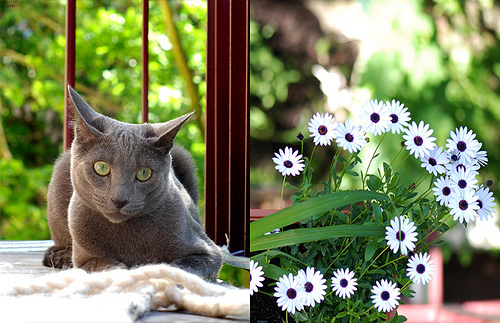

(365, 500)


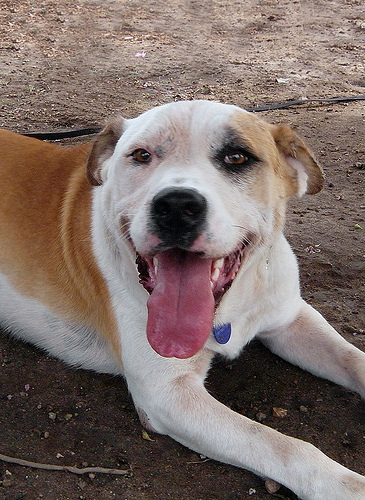

In [4]:
import PIL
import glob
from IPython.display import display
for f in glob.glob('images/*.jpg')[:10]:
  img = PIL.Image.open(f)
  print(img.size)
  display(img)

In [5]:
!pip install xmltodict

In [0]:
import xmltodict

In [0]:
with open('annotations/xmls/japanese_chin_10.xml') as f:
  r = xmltodict.parse(f.read())

In [8]:
r['annotation']['object']['bndbox']

OrderedDict([('xmin', '69'), ('ymin', '88'), ('xmax', '211'), ('ymax', '210')])

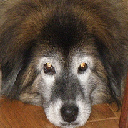

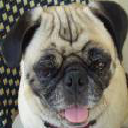

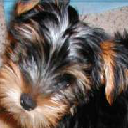

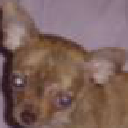

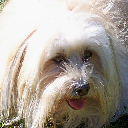

In [9]:
for fn in glob.glob('annotations/xmls/*.xml')[:5]:
  with open(fn) as f:
    r = xmltodict.parse(f.read())
  img_fn = r['annotation']['filename']
  img = PIL.Image.open('images/'+img_fn)
  bb = r['annotation']['object']['bndbox']
  x1, y1, x2, y2 = int(bb['xmin']), int(bb['ymin']), int(bb['xmax']), int(bb['ymax'])
  face = img.crop((x1,y1,x2,y2)).resize((128,128)).convert('RGB')
  display(face)

In [10]:
import sys
sys.path.insert(0, '/content/stylegan/')
import tensorflow as tf
import PIL.Image
import dnnlib.tflib as tflib
from dataset_tool import TFRecordExporter, WorkerThread, ThreadPool

W0828 15:49:06.682840 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0828 15:49:06.685041 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0828 15:49:06.686732 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [11]:
xmls = glob.glob('annotations/xmls/*.xml')
len(xmls)

3686

In [0]:
import numpy as np
face_imgs = []
for x in xmls:
    with open(x) as f:
        ann = xmltodict.parse(f.read())['annotation']
    img_fn = ann['filename']
    img = PIL.Image.open('images/'+img_fn)
    f_list =  ann['object']
    if not isinstance(f_list, list):
        f_list = [f_list]
    for obj in f_list:
        bb = obj['bndbox']
        x1, y1, x2, y2 = int(bb['xmin']), int(bb['ymin']), int(bb['xmax']), int(bb['ymax'])
        face = img.crop((x1,y1,x2,y2)).resize((128,128)).convert('RGB')
        rimg = np.array(face)
        rimg = rimg.transpose([2, 0, 1]) # HWC => CHW
        face_imgs.append(rimg)

In [13]:
resolution = 128
channels = 3

with TFRecordExporter('stylegan/datasets/animal', len(face_imgs)) as tfr:
    order = tfr.choose_shuffled_order()
    for idx in range(order.size):
        rimg = face_imgs[order[idx]]
        tfr.add_image(rimg)

Creating dataset "stylegan/datasets/animal"


W0828 15:49:24.180588 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dataset_tool.py:75: The name tf.python_io.TFRecordOptions is deprecated. Please use tf.io.TFRecordOptions instead.

W0828 15:49:24.182138 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dataset_tool.py:75: The name tf.python_io.TFRecordCompressionType is deprecated. Please use tf.compat.v1.python_io.TFRecordCompressionType instead.

W0828 15:49:24.183623 139893291665280 deprecation_wrapper.py:119] From /content/stylegan/dataset_tool.py:78: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



Added 3687 images.


In [0]:
import os
os.chdir('/content/stylegan')


In [0]:
import training.misc
import IPython.display
def save_image_grid(images, filename, drange=[0,1], grid_size=None):
    img =  training.misc.convert_to_pil_image(training.misc.create_image_grid(images, grid_size), drange)
    IPython.display.display(img)
    img.save(filename)
training.misc.save_image_grid = save_image_grid

In [0]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Main entry point for training StyleGAN and ProGAN networks."""

import copy
import dnnlib
from dnnlib import EasyDict

import config
from metrics import metric_base

#----------------------------------------------------------------------------
# Official training configs for StyleGAN, targeted mainly for FFHQ.

if 1:
    desc          = 'sgan'                                                                 # Description string included in result subdir name.
    train         = EasyDict(run_func_name='training.training_loop.training_loop')         # Options for training loop.
    G             = EasyDict(func_name='training.networks_stylegan.G_style')               # Options for generator network.
    D             = EasyDict(func_name='training.networks_stylegan.D_basic')               # Options for discriminator network.
    G_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                          # Options for generator optimizer.
    D_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                          # Options for discriminator optimizer.
    G_loss        = EasyDict(func_name='training.loss.G_logistic_nonsaturating')           # Options for generator loss.
    D_loss        = EasyDict(func_name='training.loss.D_logistic_simplegp', r1_gamma=10.0) # Options for discriminator loss.
    dataset       = EasyDict()                                                             # Options for load_dataset().
    sched         = EasyDict()                                                             # Options for TrainingSchedule.
    grid          = EasyDict(size='1080p', layout='random')                                   # Options for setup_snapshot_image_grid().
    metrics       = []                                                   # Options for MetricGroup.
    submit_config = dnnlib.SubmitConfig()                                                  # Options for dnnlib.submit_run().
    tf_config     = {'rnd.np_random_seed': 1000}                                           # Options for tflib.init_tf().

    # Dataset.
    desc += '-animal';     dataset = EasyDict(tfrecord_dir='animal');                 train.mirror_augment = True
    #desc += '-ffhq512';  dataset = EasyDict(tfrecord_dir='ffhq', resolution=512); train.mirror_augment = True
    #desc += '-ffhq256';  dataset = EasyDict(tfrecord_dir='ffhq', resolution=256); train.mirror_augment = True
    #desc += '-celebahq'; dataset = EasyDict(tfrecord_dir='celebahq');             train.mirror_augment = True
    #desc += '-bedroom';  dataset = EasyDict(tfrecord_dir='lsun-bedroom-full');    train.mirror_augment = False
    #desc += '-car';      dataset = EasyDict(tfrecord_dir='lsun-car-512x384');     train.mirror_augment = False
    #desc += '-cat';      dataset = EasyDict(tfrecord_dir='lsun-cat-full');        train.mirror_augment = False

    # Number of GPUs.
    desc += '-1gpu'; submit_config.num_gpus = 1; sched.minibatch_base = 4; sched.minibatch_dict = {4: 128, 8: 128, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8, 512: 4}
    #desc += '-2gpu'; submit_config.num_gpus = 2; sched.minibatch_base = 8; sched.minibatch_dict = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8}
    #desc += '-4gpu'; submit_config.num_gpus = 4; sched.minibatch_base = 16; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
    #desc += '-8gpu'; submit_config.num_gpus = 8; sched.minibatch_base = 32; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}

    # Default options.
    train.total_kimg = 25000
    sched.lod_initial_resolution = 4
    sched.lod_training_kimg = 200
    sched.lod_transition_kimg = 200
    sched.tick_kimg_dict = {4: 40, 8:40, 16:40, 32:40, 64:40, 128:40, 256:40, 512:30, 1024:20}
    sched.G_lrate_dict = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
    sched.D_lrate_dict = EasyDict(sched.G_lrate_dict)

    # WGAN-GP loss for CelebA-HQ.
    #desc += '-wgangp'; G_loss = EasyDict(func_name='training.loss.G_wgan'); D_loss = EasyDict(func_name='training.loss.D_wgan_gp'); sched.G_lrate_dict = {k: min(v, 0.002) for k, v in sched.G_lrate_dict.items()}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict)

    # Table 1.
    #desc += '-tuned-baseline'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 0; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-add-mapping-and-styles'; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-remove-traditional-input'; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-add-noise-inputs'; G.style_mixing_prob = 0.0
    #desc += '-mixing-regularization' # default

    # Table 2.
    #desc += '-mix0'; G.style_mixing_prob = 0.0
    #desc += '-mix50'; G.style_mixing_prob = 0.5
    #desc += '-mix90'; G.style_mixing_prob = 0.9 # default
    #desc += '-mix100'; G.style_mixing_prob = 1.0

    # Table 4.
    #desc += '-traditional-0'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 0; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-traditional-8'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 8; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-stylebased-0'; G.mapping_layers = 0
    #desc += '-stylebased-1'; G.mapping_layers = 1
    #desc += '-stylebased-2'; G.mapping_layers = 2
    #desc += '-stylebased-8'; G.mapping_layers = 8 # default


def main():
    kwargs = EasyDict(train)
    kwargs.update(G_args=G, D_args=D, G_opt_args=G_opt, D_opt_args=D_opt, G_loss_args=G_loss, D_loss_args=D_loss)
    kwargs.update(dataset_args=dataset, sched_args=sched, grid_args=grid, metric_arg_list=metrics, tf_config=tf_config)
    kwargs.submit_config = copy.deepcopy(submit_config)
    kwargs.submit_config.run_dir_root = dnnlib.submission.submit.get_template_from_path(config.result_dir)
    kwargs.submit_config.run_dir_ignore += config.run_dir_ignore
    kwargs.submit_config.run_desc = desc
    dnnlib.submit_run(**kwargs)

#----------------------------------------------------------------------------

main()

#----------------------------------------------------------------------------